**`ICUBAM`: ICU Bed Availability Monitoring and analysis in the *Grand Est région* of France during the COVID-19 epidemic.**

https://doi.org/10.1101/2020.05.18.20091264

Python notebook for the sir-like modeling (see Section IV.1 of the main paper).

(iv) visualize results with credible regions, reproducing Fig. 11 and Fig. 17(right) of the paper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os.path as op

import model_icubam as micu

In [2]:
sns.set_style('whitegrid', {'grid.linestyle': ':'})

In [3]:
data_pop = pd.read_csv(op.join('data', 'pop_dep_2020.csv'), delimiter='\t')

In [4]:
first_date = '2020-03-19'
last_date = '2020-04-27'
future_date = '2020-04-29'

In [5]:
data = pd.read_csv(op.join('data', 'all_bedcounts_2020-05-04_11h02.csv'), index_col=0)              
data = data.groupby(['date', 'department']).sum().reset_index()
data = data[data.date >= first_date]
future_data = data[(data.date >= last_date)&(data.date <= future_date)]
data = data[data.date <= last_date]

In [6]:
sites = ['Ardennes', 'Aube', 'Bas-Rhin', 'Haut-Rhin', 
         'Marne', 'Meurthe-et-Moselle', 'Meuse', 'Moselle', 'Vosges']
n_sites = len(sites)

depname2depid = {'Ardennes':8, 'Aube':10, 'Marne':51, 'Haute-Marne':52,
                 'Meurthe-et-Moselle':54, 'Meuse':55, 'Moselle':57, 'Bas-Rhin':67,
                 'Haut-Rhin':68, 'Vosges':88}

In [7]:
compute_model = micu.compute_model_seir

In [8]:
alpha = 0.05

n_days_pred = 7

In [9]:
def compute_map_cr(pop, df_samples, alpha, n_days):
    samples_sorted = df_samples.sort_values(by=['logp']).to_numpy()[:,:-1]
    indcut = np.ceil(alpha*samples_sorted.shape[0]).astype(int)

    c_hpd_min = np.zeros(n_days)
    c_hpd_min[:] = np.inf
    c_hpd_max = np.zeros(n_days)
    c_hpd_max[:] = -np.inf
    x_hpd_min = np.zeros(n_days)
    x_hpd_min[:] = np.inf
    x_hpd_max = np.zeros(n_days)
    x_hpd_max[:] = -np.inf

    for params in samples_sorted[indcut:]:
        c, x = compute_model(pop, params, n_days)
        c_hpd_min[c < c_hpd_min] = c[c < c_hpd_min]
        c_hpd_max[c > c_hpd_max] = c[c > c_hpd_max]
        x_hpd_min[x < x_hpd_min] = x[x < x_hpd_min]
        x_hpd_max[x > x_hpd_max] = x[x > x_hpd_max]
        
    return c, c_hpd_min, c_hpd_max, x, x_hpd_min, x_hpd_max

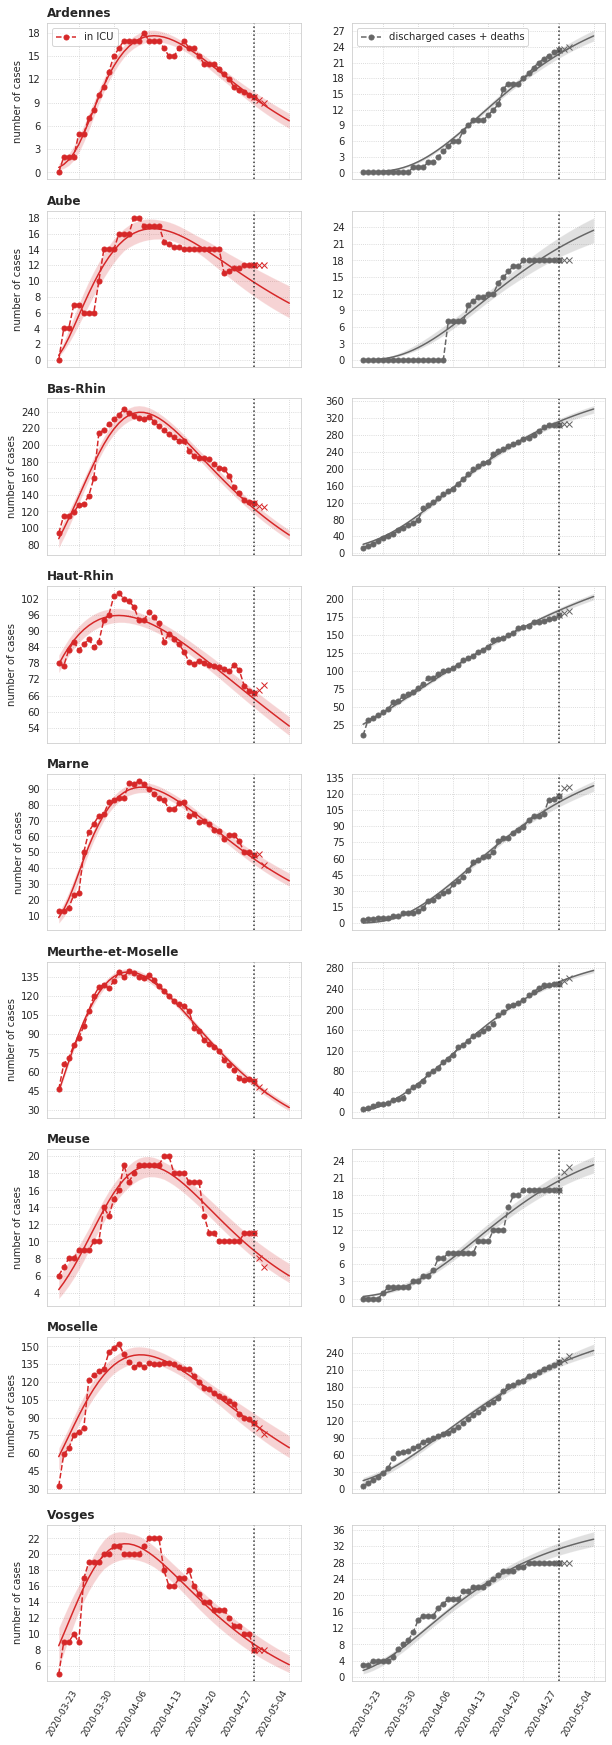

In [10]:
fh = plt.figure(figsize=(10,3.5*n_sites-1))
for k, dep in enumerate(sites):
    condition = data.department==dep
    n_days = data[condition].date.shape[0]

    df_samples = pd.read_csv(op.join(micu.model_path, 
                                   'samples', 'samples_{}_{}.csv'.format(dep.lower(), last_date)),
                           index_col=0)

    pop = data_pop[data_pop.dep=='{}'.format(depname2depid[dep])]['pop'].values[0]
    
    c, c_hpd_min, c_hpd_max, x, x_hpd_min, x_hpd_max = compute_map_cr(pop, df_samples, 
                                                                      alpha, n_days + n_days_pred)
    
    date_rg = pd.date_range(data.date.min(), periods=n_days+n_days_pred).strftime('%Y-%m-%d')

    ax = plt.subplot(n_sites, 2, 2*k+1)
    line_rea = plt.plot(data[condition].date, 
             data[condition]['n_covid_occ'].values, 
             '--o', color='tab:red', markersize=5)
    plt.plot(future_data[future_data.department==dep].date, 
             future_data[future_data.department==dep]['n_covid_occ'].values, 
             'x', color='tab:red', markersize=6)
    plt.plot(date_rg, c, color='tab:red')
    plt.fill_between(date_rg, c_hpd_min, c_hpd_max,
                     facecolor='tab:red', alpha=0.2)
    if n_days_pred > 0:
        plt.axvline(last_date, ls=':', color='0.2')
    ax.set_xticks(ax.get_xticks()[4::7])
    if k < n_sites-1:
        ax.set_xticklabels('')
    else:
        plt.xticks(rotation=60, ha='right', fontsize=9)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))   
    plt.ylabel('number of cases')        
    plt.title(dep, loc='left', fontdict={'fontweight':'bold'})
    if k==0:
        ax.legend(line_rea, ('in ICU',))

    ax = plt.subplot(n_sites, 2, 2*k+2)        
    line_out = plt.plot(data[condition].date, 
                        data[condition]['n_covid_deaths'].values
                        +data[condition]['n_covid_healed'].values, 
                        '--o', color='0.4', markersize=5) 
    plt.plot(future_data[future_data.department==dep].date, 
                        future_data[future_data.department==dep]['n_covid_deaths'].values
                        +future_data[future_data.department==dep]['n_covid_healed'].values, 
                        'x', color='0.4', markersize=6)        
    plt.plot(date_rg, x, color='0.4')
    plt.fill_between(date_rg, x_hpd_min, x_hpd_max,
                     facecolor='0.4', alpha=0.2)
    if n_days_pred > 0:
        plt.axvline(last_date, ls=':', color='0.2')

    ax.set_xticks(ax.get_xticks()[4::7])
    if k < n_sites-1:
        ax.set_xticklabels('')
    else:
        plt.xticks(rotation=60, ha='right', fontsize=9)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))   
    if k==0:
        ax.legend(line_out, ('discharged cases + deaths',))
plt.show()

fh.savefig(op.join(micu.fig_path, 'model_icubam_cr_grand-est_{}.pdf'.format(last_date)),
           bbox_inches='tight')

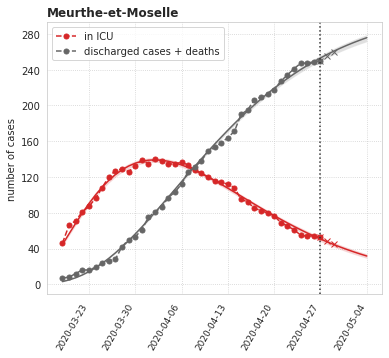

In [11]:
# Fig. 11 -- Meurthe et Moselle

k = 5
dep = sites[k]

fh = plt.figure(figsize=(6,5))

condition = (data.department==dep)
n_days = data[condition].date.shape[0]
df_samples = pd.read_csv(op.join(micu.model_path, 
                               'samples', 'samples_{}_{}.csv'.format(dep.lower(), last_date)),
                         index_col=0)
pop = data_pop[data_pop.dep=='{}'.format(depname2depid[dep])]['pop'].values[0]

c, c_hpd_min, c_hpd_max, x, x_hpd_min, x_hpd_max = compute_map_cr(pop, df_samples, 
                                                                  alpha, n_days + n_days_pred)
    
date_rg = pd.date_range(data.date.min(), periods=n_days+n_days_pred).strftime('%Y-%m-%d')

ax = plt.subplot(111)
line_rea = plt.plot(data[condition].date, 
         data[condition]['n_covid_occ'].values, 
         '--o', color='tab:red', markersize=5)
plt.plot(future_data[future_data.department==dep].date, 
         future_data[future_data.department==dep]['n_covid_occ'].values, 
         'x', color='tab:red', markersize=6)
plt.plot(date_rg, c, color='tab:red')
plt.fill_between(date_rg, c_hpd_min, c_hpd_max,
                 facecolor='tab:red', alpha=0.2)
line_out = plt.plot(data[condition].date, 
                    data[condition]['n_covid_deaths'].values
                    +data[condition]['n_covid_healed'].values, 
                    '--o', color='0.4', markersize=5) 
plt.plot(future_data[future_data.department==dep].date, 
                    future_data[future_data.department==dep]['n_covid_deaths'].values
                    +future_data[future_data.department==dep]['n_covid_healed'].values, 
                    'x', color='0.4', markersize=6)        
plt.plot(date_rg, x, color='0.4')
plt.fill_between(date_rg, x_hpd_min, x_hpd_max,
                 facecolor='0.4', alpha=0.2)

if n_days_pred > 0:
    plt.axvline(last_date, ls=':', color='0.2')

ax.set_xticks(ax.get_xticks()[4::7])
plt.xticks(rotation=60, ha='right', fontsize=9)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))   
plt.ylabel('number of cases')        
plt.title(dep, loc='left', fontdict={'fontweight':'bold'})
ax.legend(handles=[line_rea[0], line_out[0]], 
          labels=['in ICU','discharged cases + deaths'])
plt.show()

fh.savefig(op.join(micu.fig_path, 'model_icubam_meurthe-et-moselle.pdf'),
           bbox_inches='tight')